In [1]:
import datetime, logging, os, sys, math, random
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import albumentations as alb

from ImageDataAugmentor.image_data_augmentor import *
from sklearn.model_selection import train_test_split, StratifiedKFold
from albumentations.core.composition import Compose, OneOf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
devices = tf.config.list_physical_devices('GPU')
for device in devices:
   tf.config.experimental.set_memory_growth(device, True) 
print(devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
TASK = "sorghum-id"
TASK_ID = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PATH = os.path.abspath(os.path.join(os.getcwd() ,"../../../../datasets/sorghum-id-fgvc-9"))+"/"

train_dir = PATH+'train_images/'
test_dir = PATH+'test/'

save_dir    = '../results/sorghum/'+TASK_ID+'/'
log_dir     = os.path.join("../logs/",''.join([TASK,"-",TASK_ID]))
model_dir   = os.path.join("../models/",''.join([TASK,"-",TASK_ID]))+'/'

In [4]:
NUM_GPUS = len(devices)
base_batch_size = 16
batch_size = base_batch_size*NUM_GPUS
epoch = 10
WIDTH = 512
HEIGHT = 512

In [5]:
image_df = pd.read_csv(PATH+'train_cultivar_mapping.csv')
image_df.dropna(inplace=True)

DEBUG = False

if DEBUG:
    image_df=image_df[:2000]
    epoch = 20

image_df

,image,cultivar
0,2017-06-21__11-32-09-227.png,PI_152923
1,2017-06-27__10-36-57-694.png,PI_152923
2,2017-06-13__12-10-43-125.png,PI_152923
3,2017-06-03__12-37-57-818.png,PI_152923
4,2017-06-03__12-37-24-028.png,PI_152923
...,...,...
22630,2017-06-04__13-32-11-825.png,PI_152967
22631,2017-06-04__13-33-43-417.png,PI_152967
22632,2017-06-20__12-19-56-066.png,PI_152967
22633,2017-06-09__12-51-11-655.png,PI_152967


In [6]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, valid_index in kfold.split(image_df['image'],image_df['cultivar']):
    train_images, valid_images = image_df['image'].iloc[train_index], image_df['image'].iloc[valid_index]
    train_cultivar, valid_cultivar = image_df['cultivar'].iloc[train_index], image_df['cultivar'].iloc[valid_index]

In [7]:
train_df= pd.DataFrame({'image':train_images, 'cultivar':train_cultivar})
val_df= pd.DataFrame({'image':valid_images, 'cultivar':valid_cultivar})

In [8]:
len(train_df), len(val_df)

(15090, 7545)

In [9]:
transform = Compose([
            alb.RandomResizedCrop(height=HEIGHT, width=WIDTH),
            alb.Flip(p=0.5),
            alb.RandomRotate90(p=0.5),
            alb.ShiftScaleRotate(p=0.5),
            alb.HueSaturationValue(p=0.5),
            alb.OneOf([
                alb.RandomBrightnessContrast(p=0.5),
                alb.RandomGamma(p=0.5),
            ], p=0.5),
            OneOf([
                alb.Blur(p=0.1),
                alb.GaussianBlur(p=0.1),
                alb.MotionBlur(p=0.1),
            ], p=0.1),
            OneOf([
                alb.GaussNoise(p=0.1),
                alb.ISONoise(p=0.1),
                alb.GridDropout(ratio=0.5, p=0.2),
                alb.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)
            ], p=0.2)
        ])

In [10]:
train_datagen = ImageDataAugmentor(augment=transform)
val_datagen = ImageDataAugmentor()

In [11]:
train_augmented = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    shuffle=True,
    directory=train_dir,
    x_col='image',
    y_col='cultivar',
    class_mode='categorical',
    target_size=(HEIGHT,WIDTH),
    batch_size=batch_size)

Found 14793 validated image filenames belonging to 100 classes.


/mnt/shared/scratch/fmacfarl/apps/conda/envs/tf2_6_0/lib/python3.9/site-packages/ImageDataAugmentor/dataframe_iterator.py:285: UserWarning: Found 297 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [12]:
val_augmented = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    shuffle=True,
    directory=train_dir,
    x_col='image',
    y_col='cultivar',
    class_mode='categorical',
    target_size=(HEIGHT,WIDTH),
    batch_size=batch_size)

Found 7400 validated image filenames belonging to 100 classes.


/mnt/shared/scratch/fmacfarl/apps/conda/envs/tf2_6_0/lib/python3.9/site-packages/ImageDataAugmentor/dataframe_iterator.py:285: UserWarning: Found 145 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [13]:
num_classes = len(train_augmented.class_indices)
num_classes

100

In [14]:
class_id, num_images = np.unique(train_augmented.classes,return_counts=True)
max_value = max(num_images)
class_weights = {c : max_value/n for c,n in zip(class_id, num_images)}

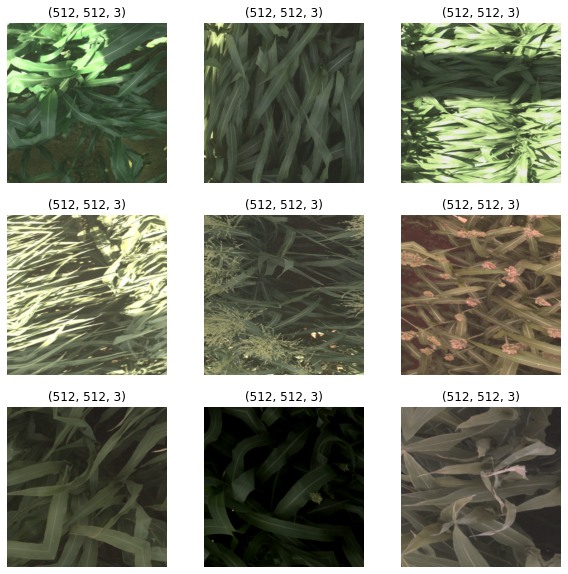

In [15]:
plt.figure(figsize=(10, 10))
batch=train_augmented.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.title(batch[0][i].shape)
    plt.axis("off")

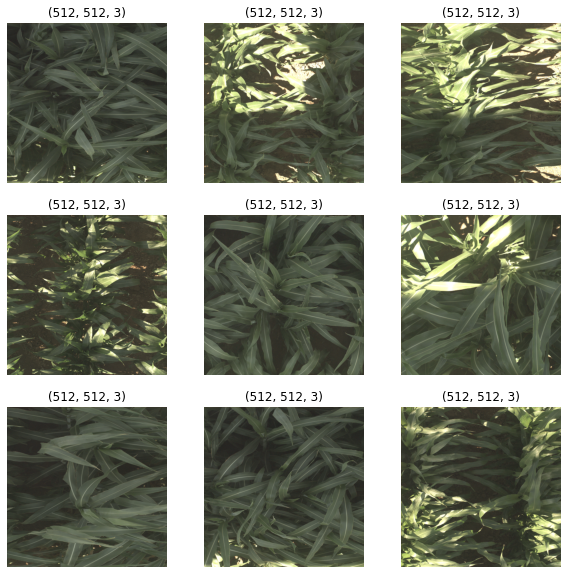

In [16]:
plt.figure(figsize=(10, 10))
batch=val_augmented.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.title(batch[0][i].shape)
    plt.axis("off")

In [17]:
def create_model():

    tf.keras.backend.clear_session()

    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    with strategy.scope():
        model = Sequential([
            tf.keras.Input(shape=(HEIGHT,WIDTH,3)),
            tf.keras.applications.EfficientNetB4(include_top=False,weights='imagenet',input_shape=(HEIGHT,WIDTH,3)),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])
    model.summary()

    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])


    return model

Number of devices: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 16, 16, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               179300    
Total params: 17,853,123
Trainable params: 17,727,916
Non-trainable params: 125,207
_________________________________________________________________


In [18]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=7,
                   verbose=1,
                   restore_best_weights=True)

cp = ModelCheckpoint(save_dir + 'effnetB4-{epoch:04d}.ckpt',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True,
                     save_weights_only=False,
                     mode='min' )

sv = ModelCheckpoint(model_dir + 'effnetB4-{epoch:04d}.h5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=False,
                     save_weights_only=False,
                     mode='min' )

sv_best = ModelCheckpoint(model_dir + 'effnetB4-optimal.h5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True,
                     save_weights_only=False,
                     mode='min' )

csv = tf.keras.callbacks.CSVLogger('../history/'+TASK_ID+'.csv')

tb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.4,
                                                 verbose=1,
                                                 patience=2, 
                                                 min_lr=1e-6)

In [19]:
STEP_SIZE_TRAIN = train_augmented.n//train_augmented.batch_size
STEP_SIZE_VALID = val_augmented.n//val_augmented.batch_size

In [ ]:
model = create_model()

In [20]:
%%time

history = model.fit(train_augmented,
                    epochs=epoch,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    callbacks=[es,tb,sv,sv_best,reduce_lr,csv],
                    verbose=1,
                    class_weight=class_weights,
                    validation_data=val_augmented,
                    validation_steps=STEP_SIZE_VALID)

/mnt/shared/scratch/fmacfarl/apps/conda/envs/tf2_6_0/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/10
462/462 [==============================] - 970s 2s/step - loss: 5.6255 - accuracy: 0.0659 - val_loss: 3.1570 - val_accuracy: 0.1969

Epoch 00001: saving model to ../models/sorghum-id-20220420-104704/effnetB4-0001.h5

Epoch 00001: val_loss improved from inf to 3.15702, saving model to ../models/sorghum-id-20220420-104704/effnetB4-optimal.h5
Epoch 2/10
462/462 [==============================] - 831s 2s/step - loss: 3.8611 - accuracy: 0.2684 - val_loss: 1.7544 - val_accuracy: 0.5122

Epoch 00002: saving model to ../models/sorghum-id-20220420-104704/effnetB4-0002.h5

Epoch 00002: val_loss improved from 3.15702 to 1.75437, saving model to ../models/sorghum-id-20220420-104704/effnetB4-optimal.h5
Epoch 3/10
462/462 [==============================] - 797s 2s/step - loss: 2.7752 - accuracy: 0.4383 - val_loss: 0.9893 - val_accuracy: 0.7218

Epoch 00003: saving model to ../models/sorghum-id-20220420-104704/effnetB4-0003.h5

Epoch 00003: val_loss improved from 1.75437 to 0.98925, saving